# Recreating " Melanoma diagnosis using deep learning techniques on dermatoscopic images"

## Imports and Data Processing

### Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import multiprocessing
import torch.nn as nn
import numpy as np
#import torchvision
import torchvision.transforms.v2 as v2
from torchvision.transforms.v2 import Resize, Lambda
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from dataloader import ISICImageDataset
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
device = torch.device(device)

from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT

Using cuda device


### Data Processing

In [2]:
#constants:
batch_size = 8
dataType = torch.float32
num_workers = multiprocessing.cpu_count()//2
transforms = v2.Compose(
[
    
    weights.transforms(),
    Resize((256,256)),
]
)

Train_Dataset      = ISICImageDataset("Dataset_2017\\","Training",transform=transforms, target_transform=Lambda(lambda y: torch.zeros( 2, dtype=torch.int64).scatter_(dim=0, index=torch.tensor(int(y)), value=1)))
Validation_Dataset = ISICImageDataset("Dataset_2017\\","Validation", transform=transforms, target_transform=Lambda(lambda y: torch.zeros(
                                        2, dtype=torch.int64).scatter_(dim=0, index=torch.tensor(int(y)), value=1)))
Test_Dataset       = ISICImageDataset("Dataset_2017\\","Test", transform=transforms, target_transform=Lambda(lambda y: torch.zeros(
                                        2, dtype=torch.int64).scatter_(dim=0, index=torch.tensor(int(y)), value=1)))

data_loader_params = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': 0,  # Number of subprocesses to use for data loading
    'persistent_workers': False,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': True,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': 'cuda' ,  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
    'collate_fn': lambda batch: tuple(zip(*batch)),
}
train_dataloader      = DataLoader(Train_Dataset, **data_loader_params, shuffle=True)
validation_dataloader = DataLoader(Validation_Dataset, **data_loader_params, shuffle=True)
test_dataloader       = DataLoader(Test_Dataset, **data_loader_params, shuffle=True)

### Training function

In [3]:
def train_one_epoch(epoch_index, tb_writer, model, training_loader,optimizer,lr_scheduler,scaler,loss_fn):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, targets = data
        inputs = torch.stack(inputs)
        #inputs.to(device)             labels, masks, bb,
        #target.to(device)
        '''targets = []
        for i in range(batch_size):
            d = {}
            d['boxes'] = bb[i]
            d['labels'] = labels[i]
            d['masks'] = masks[i]
            targets.append(d)'''
        #target = {}
        #print(bb.squeeze(1).shape)
        #target["boxes"] = bb.squeeze(1)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        #target["boxes"] = target["boxes"].squeeze(1)
        #target["masks"] = target["masks"].squeeze(1)
        # Make predictions for this batch
        with torch.amp.autocast(torch.device(device).type):
            losses = model(inputs.to(device), move_data_to_device(targets, device))
            # Compute the loss and its gradients
            loss = losses["loss_box_reg"]+ losses["loss_rpn_box_reg"] + losses["loss_mask"]
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            old_scaler = scaler.get_scale()
            scaler.update()
            new_scaler = scaler.get_scale()
            if new_scaler >= old_scaler:
                lr_scheduler.step()
        else:
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
        #loss.backward()

        # Adjust learning weights
        #optimizer.step()

        # Gather data and report
        running_loss += loss
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

## R_CNN initialization

In [ ]:
mask_model_train = True
mask_model_path = 'Trained_Models\\Mask-RCNN_Best'
lr = 0.01
EPOCHS = 5
mask_model = maskrcnn_resnet50_fpn_v2(weights=weights, progress=False, trainable_backbone_layers=5, num_classes=None)
loss_fn = torch.nn.L1Loss()

# Get the number of input features for the classifier
in_features_box = mask_model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = mask_model.roi_heads.mask_predictor.conv5_mask.in_channels

# Get the numbner of output channels for the Mask Predictor
dim_reduced = mask_model.roi_heads.mask_predictor.conv5_mask.out_channels

# Replace the box predictor
mask_model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features_box, num_classes=2)

# Replace the mask predictor
mask_model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=dim_reduced, num_classes=2)#
optimizer = torch.optim.SGD(mask_model.parameters(), lr=lr, momentum=0.8,weight_decay=0.00001)
scaler = torch.amp.GradScaler("cuda")
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=EPOCHS*len(train_dataloader))
mask_model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
if mask_model_train:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/Mask_RCNN{}'.format(timestamp))
    epoch_number = 0
    EPOCHS = 5

    best_vloss = 1_000_000.

    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        mask_model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer,mask_model,train_dataloader,optimizer,lr_scheduler,scaler,loss_fn)


        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        mask_model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_dataloader):
                vinputs, vtargets = vdata
                vtargets = move_data_to_device(vtargets, device)
                with torch.amp.autocast(torch.device(device).type):
                    voutputs = mask_model(torch.stack(vinputs).to(device))
                    for i, vout in enumerate(voutputs):
                        vloss = loss_fn(vout["boxes"][vout["scores"].argmax().item()].unsqueeze(0), vtargets[i]["boxes"])
                        running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(mask_model.state_dict(), mask_model_path)

        epoch_number += 1


EPOCH 1:
  batch 100 loss: 1.1032108068466187
  batch 200 loss: 0.6714327931404114


c:\Users\jacob\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([100, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


LOSS train 0.6714327931404114 valid 2128.19384765625
EPOCH 2:
  batch 100 loss: 0.586331844329834
  batch 200 loss: 0.5350174307823181
LOSS train 0.5350174307823181 valid 2162.1640625
EPOCH 3:
  batch 100 loss: 0.5094115138053894
  batch 200 loss: 0.5082396864891052
LOSS train 0.5082396864891052 valid 2176.3505859375
EPOCH 4:
  batch 100 loss: 0.48406368494033813
  batch 200 loss: 0.4865741729736328
LOSS train 0.4865741729736328 valid 2159.264892578125
EPOCH 5:
  batch 100 loss: 0.4742978811264038
  batch 200 loss: 0.47442179918289185
LOSS train 0.47442179918289185 valid 2175.722412109375


Here we can load our lowest loss model that we trained:

In [9]:
if not mask_model_train:
    checkpoint = torch.load(mask_model_path)
    mask_model.load_state_dict(checkpoint)

Now we can load a picture and show the correct and predicted bounding boxes

In [10]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = v2.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
test_features, targets = next(iter(test_dataloader))
mask_model.eval()
with torch.amp.autocast(torch.device(device).type):
    pred_targets = mask_model(torch.stack(test_features).to(device))
#plt.imshow(img, cmap="rgb")


tensor([0.7780, 0.7705, 0.7592, 0.7585, 0.7422, 0.7380, 0.7362, 0.7267, 0.7261,
        0.7228, 0.7198, 0.7177, 0.7146, 0.7130, 0.7067, 0.7032, 0.7032, 0.7030,
        0.7001, 0.6996, 0.6994, 0.6982, 0.6966, 0.6965, 0.6893, 0.6891, 0.6890,
        0.6888, 0.6870, 0.6864, 0.6863, 0.6853, 0.6849, 0.6832, 0.6810, 0.6765,
        0.6753, 0.6737, 0.6736, 0.6732, 0.6717, 0.6714, 0.6711, 0.6695, 0.6691,
        0.6688, 0.6658, 0.6645, 0.6635, 0.6632, 0.6623, 0.6607, 0.6607, 0.6595,
        0.6594, 0.6589, 0.6587, 0.6575, 0.6561, 0.6558, 0.6553, 0.6548, 0.6547,
        0.6546, 0.6530, 0.6527, 0.6520, 0.6515, 0.6513, 0.6512, 0.6500, 0.6500,
        0.6467, 0.6464, 0.6458, 0.6432, 0.6417, 0.6400, 0.6367, 0.6363, 0.6356,
        0.6354, 0.6351, 0.6342, 0.6320, 0.6315, 0.6310, 0.6283, 0.6280, 0.6261,
        0.6260, 0.6249, 0.6242, 0.6228, 0.6219, 0.6189, 0.6171, 0.6168, 0.6163,
        0.6161], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([[ 94.5416, 182.9090, 151.5384, 215.1710]], device='c

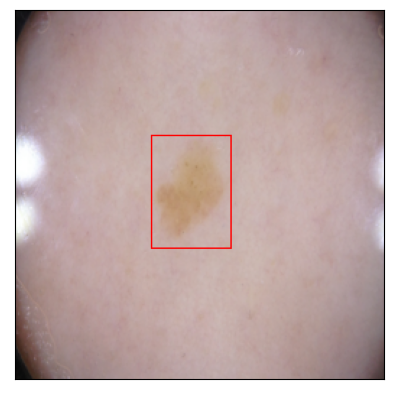

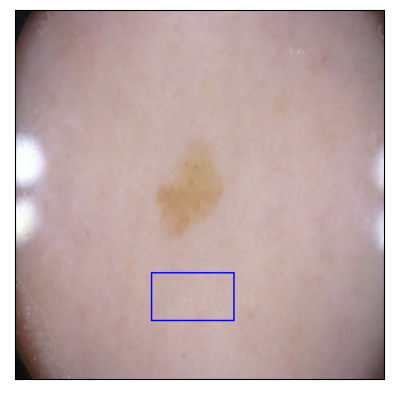

In [11]:
img = test_features[1].squeeze()
label = targets[1]["labels"]
print(pred_targets[1]["scores"])
print( pred_targets[1]["boxes"][pred_targets[1]["scores"].argmax().item()].unsqueeze(0) )
correct_boxes = draw_bounding_boxes(img, targets[1]["boxes"], colors="red")
pred_boxes = draw_bounding_boxes(img, pred_targets[1]["boxes"][pred_targets[1]["scores"].argmax().item()].unsqueeze(0), colors="Blue")
print(targets[1]["boxes"])
print(pred_targets[1]["boxes"][0].unsqueeze(0))
show(correct_boxes)
show(pred_boxes)
#plt.show()